In [33]:
%matplotlib inline

import matplotlib as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.preprocessing import Imputer, OneHotEncoder, StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

## Data Exploration

In [3]:
housing_data = pd.read_csv("./datasets/housing.csv")
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [5]:
housing_data["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

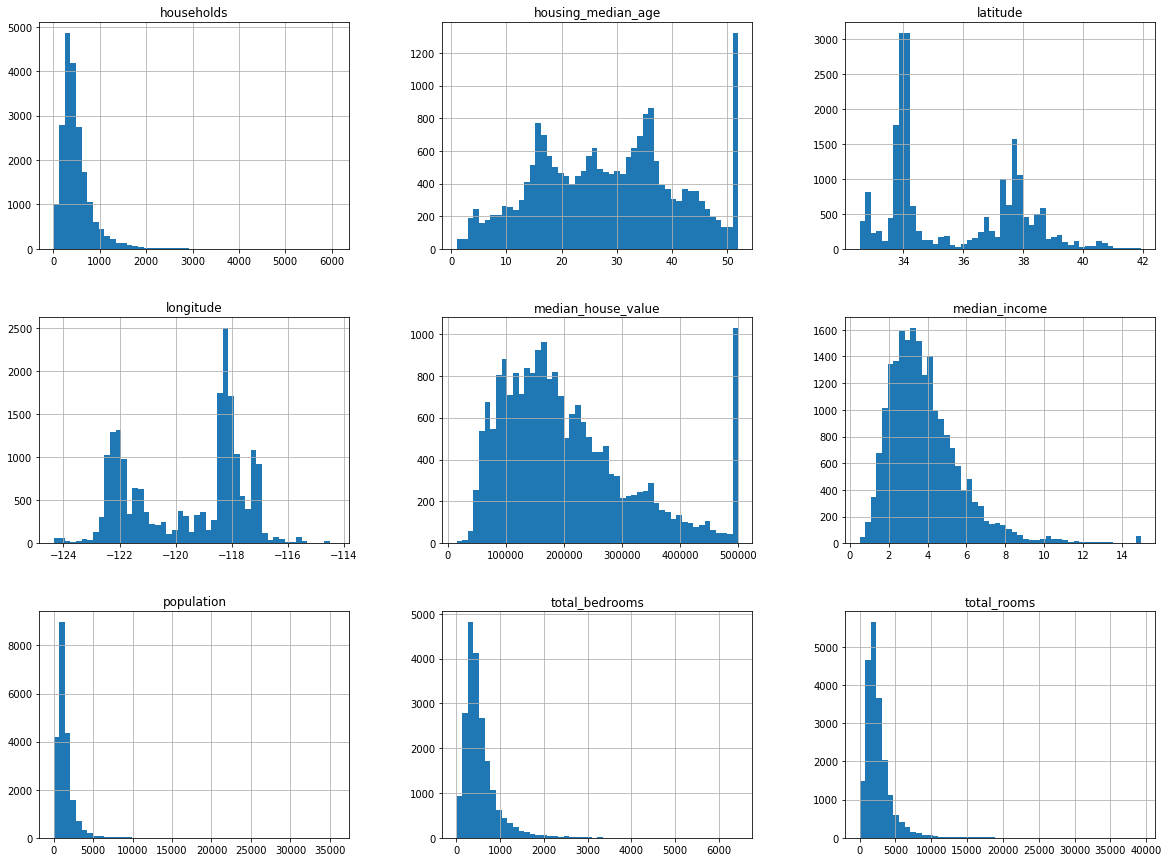

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
housing_data.hist(bins=50, figsize=(20,15))
plt.show()

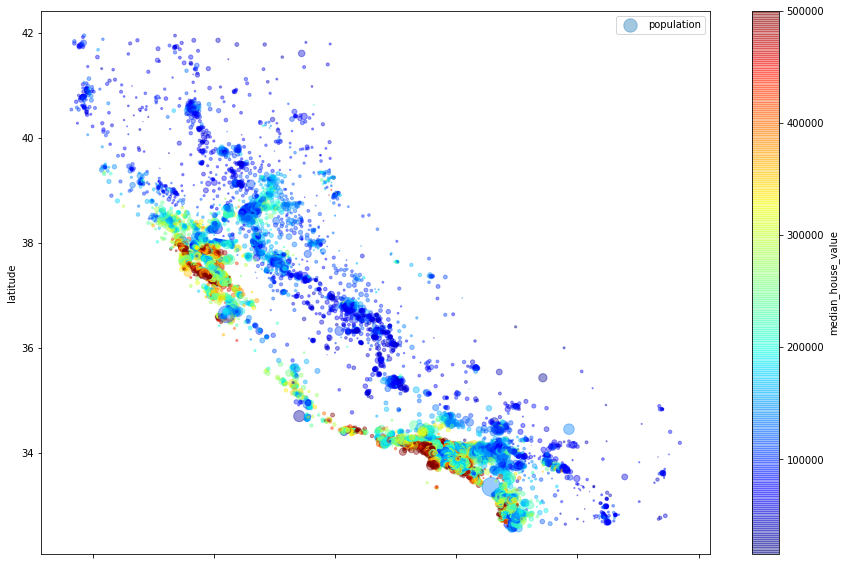

In [7]:
housing_data.plot(kind="scatter", x="longitude",y="latitude", alpha=0.4, s=housing_data["population"]/100, label="population", figsize=(15,10), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

In [8]:
housing_data["rooms_per_household"] = housing_data["total_rooms"]/housing_data["households"]
housing_data["bedrooms_per_room"] = housing_data["total_bedrooms"]/housing_data["total_rooms"]
housing_data["population_per_household"] = housing_data["population"]/housing_data["households"]

In [9]:
corr_matrix = housing_data.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f7aa908>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10ef486a0>]], dtype=object)

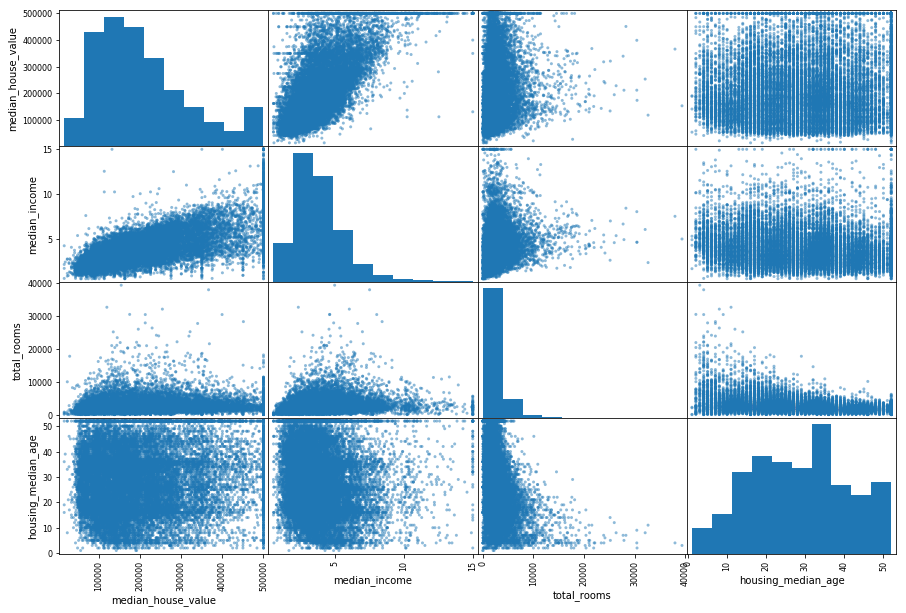

In [10]:
attributes = ["median_house_value", "median_income","total_rooms","housing_median_age"]
pd.plotting.scatter_matrix(housing_data[attributes],figsize=(15,10))

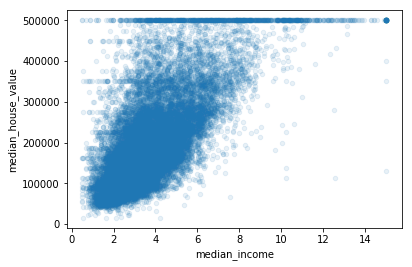

In [11]:
housing_data.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

## Data Preperation 

In [12]:
data_train, data_test = train_test_split(housing_data, test_size=0.20, random_state=42)

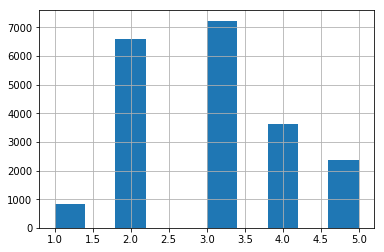

In [13]:
housing_data["income_cat"] = np.ceil(housing_data["median_income"] / 1.5)
housing_data["income_cat"].where(housing_data["income_cat"] < 5, 5, inplace=True)
housing_data["income_cat"].hist()

In [14]:
income_split = StratifiedShuffleSplit(n_splits=1, test_size=.02, random_state=42)
for train_index, test_index in income_split.split(housing_data, housing_data["income_cat"]):
        strat_train_set = housing_data.loc[train_index]
        strat_test_set = housing_data.loc[test_index]

strat_test_set["income_cat"].value_counts()/ len(strat_test_set)

3.0    0.351090
2.0    0.319613
4.0    0.176755
5.0    0.113801
1.0    0.038741
Name: income_cat, dtype: float64

In [15]:
for ds in [strat_test_set, strat_train_set]:
    ds.drop("income_cat", axis=1, inplace=True)

In [16]:
imputer = Imputer(strategy="median")
housing_num = strat_test_set.drop("ocean_proximity", axis=1).drop("median_house_value", axis=1)
imputer.fit(housing_num)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

housing_labels = strat_train_set["median_house_value"].copy()
housing = strat_train_set.drop("median_house_value", axis=1)

In [17]:
housing_cat_encoded, housing_categories = strat_test_set["ocean_proximity"].factorize()

In [18]:
print(housing_cat_encoded)
print(housing_categories)

[0 0 1 0 2 0 1 1 1 0 1 1 1 3 1 0 0 0 1 2 1 0 0 1 1 0 0 0 1 3 0 1 0 1 0 2 0
 0 1 0 2 1 3 0 2 1 0 3 0 1 0 1 0 2 0 0 2 1 0 1 3 3 0 1 0 2 1 3 0 0 0 3 3 3
 0 1 1 0 0 0 3 0 1 0 0 1 1 3 0 3 0 0 1 2 0 2 2 0 1 3 0 0 2 1 1 1 1 0 0 0 0
 0 0 1 2 0 0 2 1 0 3 1 0 0 2 1 0 1 0 0 3 1 1 1 3 0 1 3 2 0 1 0 0 2 1 3 1 1
 2 0 0 0 2 1 2 1 0 1 0 0 1 0 0 3 0 2 0 0 1 1 1 0 0 3 3 0 1 2 2 1 0 1 3 0 1
 0 0 3 0 1 1 1 0 0 2 1 1 0 0 0 0 1 0 2 0 1 3 0 0 2 0 0 1 0 3 1 2 2 1 2 1 1
 3 3 0 1 1 2 0 1 0 0 1 0 2 0 3 0 0 0 2 0 1 0 2 0 1 0 2 0 1 0 0 1 1 0 2 2 2
 1 1 3 0 0 1 1 0 1 1 1 1 0 3 2 0 0 2 3 3 0 0 0 4 3 0 0 0 1 0 1 1 3 2 0 1 1
 0 0 1 0 2 0 2 0 3 0 0 0 0 1 1 0 3 3 1 0 0 0 0 0 0 2 0 0 1 1 1 0 1 0 2 2 0
 3 2 0 1 1 0 1 1 1 0 1 0 3 0 1 0 2 1 1 0 2 1 2 1 3 0 2 1 0 2 1 2 0 2 1 1 0
 2 2 0 0 0 0 2 1 0 0 0 1 2 1 0 3 0 0 2 2 2 0 3 2 1 2 0 1 1 2 0 1 1 0 0 1 0
 1 0 0 3 0 1]
Index(['<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND'], dtype='object')


In [19]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

In [20]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

In [24]:
cat_attribs = ["ocean_proximity"]
num_attribs = [x for x in housing_num if x != "median_house_value" ]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attrs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('encode_data', MyLabelBinarizer()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])


housing_prepared = full_pipeline.fit_transform(housing)

In [25]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

/Users/adacoope1/Library/Python/3.6/lib/python/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
some_data = housing[:5]
some_lables =  housing_labels[:5]

some_data_prepared = full_pipeline.transform(some_data)
print("Predictions: ", lin_reg.predict(some_data_prepared))

Predictions:  [ 240104.  134056.  249120.  197192.  151280.]


In [27]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
print(np.sqrt(lin_mse)) 

67888.6087441


In [32]:
lin_scores = cross_val_score(lin_red, housing_prepared, housing_lables, scoring="neg_mean_squared_error",cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

NameError: name 'lin_red' is not defined

In [34]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [36]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
print(lin_rmse_scores)

[ 67720.6446521   68062.5551122   68284.27704673  67915.85288276
  72074.83623737  65304.63867674  67171.59867066  65896.01874635
  66081.41946975  72545.44295563]
